In [4]:
#Imports
import covasim as cv
from datetime import date, timedelta

Covasim 2.1.2 (2021-03-31) — © 2021 by IDM


In [5]:
## Date Extraction
today = date.today()

# Function to format date into proper string
def format_day(date):
    return date.strftime("%Y-%m-%d")

Initializing sim with 1000 people for 55 days
Initializing sim with 1000 people for 55 days
  Running "Baseline": 2021-04-03 ( 0/55) (0.12 s)  ———————————————————— 2%
  Running "With beta changes": 2021-04-03 ( 0/55) (0.14 s)  ———————————————————— 2%
  Running "Baseline": 2021-04-13 (10/55) (0.24 s)  •••————————————————— 20%
  Running "With beta changes": 2021-04-13 (10/55) (0.26 s)  •••————————————————— 20%
  Running "Baseline": 2021-04-23 (20/55) (0.35 s)  •••••••————————————— 38%
  Running "With beta changes": 2021-04-23 (20/55) (0.35 s)  •••••••————————————— 38%
  Running "Baseline": 2021-05-03 (30/55) (0.44 s)  •••••••••••————————— 55%
  Running "With beta changes": 2021-05-03 (30/55) (0.44 s)  •••••••••••————————— 55%
  Running "Baseline": 2021-05-13 (40/55) (0.54 s)  ••••••••••••••—————— 73%
  Running "With beta changes": 2021-05-13 (40/55) (0.55 s)  ••••••••••••••—————— 73%
  Running "With beta changes": 2021-05-23 (50/55) (0.63 s)  ••••••••••••••••••—— 91%
  Running "Baseline"

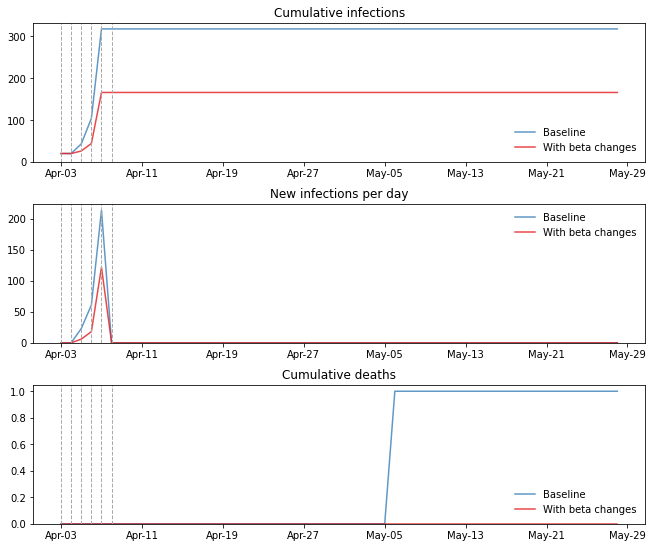

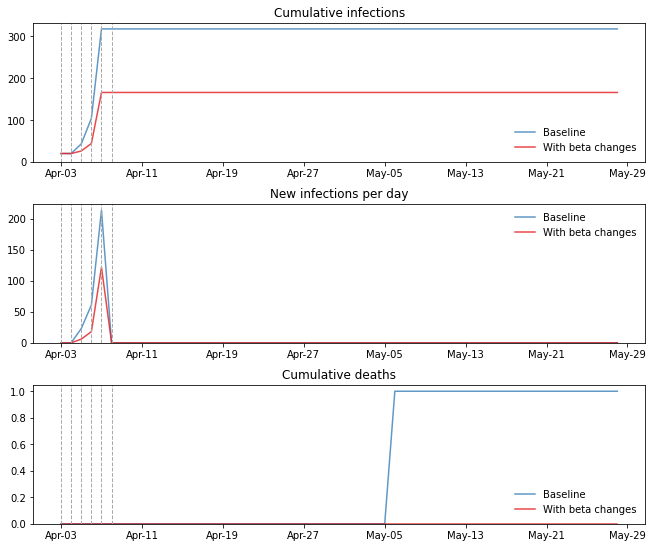

In [14]:
# Adjust model params here
event_length = 5 
baseline_beta = 6
mitigation_beta = 1.2
pop = 1000
# For time to death, should we just make it kill immediately by adjusting exp2inf and crit2die?

# Get start and end date of event, starting today
d1 = format_day(today)
d2 = format_day(today + timedelta(days = event_length + 50))

pars = dict(
    start_day = d1,
    end_day   = d2,
    pop_type  = 'hybrid',
    pop_size = pop
)

# Baseline event transmissibility
event = cv.dynamic_pars(beta=dict(days=list(range(event_length+1)), vals=[baseline_beta]*(event_length) + [0]))
orig_sim = cv.Sim(pars, interventions=event, label='Baseline')

# Mitigation event transmissibility
event_mitigate = cv.dynamic_pars(beta=dict(days=list(range(event_length+1)), vals=[mitigation_beta]*(event_length) + [0]))
sim = cv.Sim(pars, interventions=event_mitigate, label='With beta changes')

# Run and plot
msim = cv.MultiSim([orig_sim, sim])
msim.run()
msim.plot()

